# Figure 1: Adhesome in GM12878 HiC

In [16]:
# Import standard libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
from brokenaxes import brokenaxes
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import adjusted_mutual_info_score
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import communities as com
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_mutual_info_score
from networkx.algorithms.community.kclique import k_clique_communities
import pybedtools
import time
from tqdm import tqdm
import random
import OmicsIntegrator as oi
import gseapy
from gseapy.plot import barplot, dotplot
from ortools.linear_solver import pywraplp
# Custom libraries
import utils as lu
# Reload modules in case of modifications
reload(lu)

<module 'utils' from '/home/louiscam/projects/gpcr/code/figures4/analysis_GM12878/utils.py'>

In [52]:
# Specify all directories
norm = 'INTERKR'
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = f'/home/louiscam/projects/gpcr/save/processed_hic_data/processed_hic_data_GM12878/final_BP250000_intraKR_inter{norm}/'
# Directory of epigenomic data
epigenome_dir = '/home/louiscam/projects/gpcr/data/regulatory_data/regulatory_data_GM12878/'
processed_epigenome_data_dir = '/home/louiscam/projects/gpcr/save/processed_regulatory_marks/processed_epigenome_data_GM12878/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

In [53]:
# Relevant information
cell_type = 'GM12878'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

### Load gene data

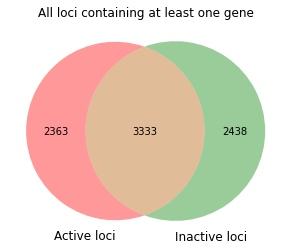

In [54]:
# Active/inactive genes (from clustering)
active_genes = pickle.load(open(saving_dir+'active_genes_GM12878.pkl','rb'))
inactive_genes = pickle.load(open(saving_dir+'inactive_genes_GM12878.pkl','rb'))
# Define active/inactive loci as the loci of active/inactive genes
gene2locus = pickle.load(open(saving_dir+'gene2locus.pkl','rb'))
all_active_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in active_genes])))
all_inactive_loci = np.unique(list(itertools.chain.from_iterable([gene2locus[g] for g in inactive_genes])))
plt.figure()
venn2(subsets = (set(all_active_loci), set(all_inactive_loci)), 
      set_labels = ('Active loci', 'Inactive loci'))
plt.title('All loci containing at least one gene')
plt.show()
# Remove inactive loci from active loci
all_active_loci = np.array(list(set(all_active_loci)-set(all_inactive_loci)))

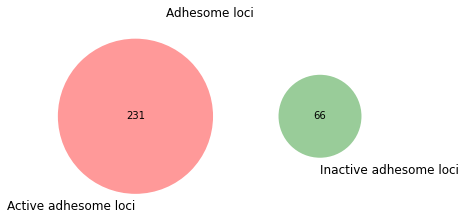

In [55]:
# Adhesome genes
active_adhesome_genes = pickle.load(open(saving_dir+'active_adhesome_genes_GM12878.pkl','rb'))
inactive_adhesome_genes = pickle.load(open(saving_dir+'inactive_adhesome_genes_GM12878.pkl','rb'))
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl','rb'))
# Define active adhesome loci as the loci of active adhesome genes (remove from the active set any locus in the
# intersection)
all_adhesome_loci = adhesome_chr_loci['locus_id'].unique()
active_adhesome_loci = adhesome_chr_loci[
    adhesome_chr_loci['gene'].isin(active_adhesome_genes)]['locus_id'].unique()
inactive_adhesome_loci = adhesome_chr_loci[
    adhesome_chr_loci['gene'].isin(inactive_adhesome_genes)]['locus_id'].unique()
intersection = set(active_adhesome_loci).intersection(set(inactive_adhesome_loci))
active_adhesome_loci = np.array(list(set(active_adhesome_loci)-set(inactive_adhesome_loci)))
# Redefine activity column of locus
adhesome_chr_loci['active'] = adhesome_chr_loci['locus_id'].isin(active_adhesome_loci)
plt.figure()
venn2(subsets = (set(active_adhesome_loci), set(inactive_adhesome_loci)), 
      set_labels = ('Active adhesome loci', 'Inactive adhesome loci'))
plt.title('Adhesome loci')
plt.show()

### Active/inactive adhesome loci per chromosome

Number of active adhesome loci = 231
Number of inactive adhesome loci = 66


<Figure size 432x288 with 0 Axes>

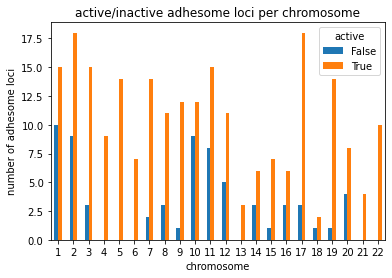

In [56]:
# Basic statistics
print('Number of active adhesome loci = '+str(len(active_adhesome_loci)))
print('Number of inactive adhesome loci = '+str(len(inactive_adhesome_loci)))
# Plot number of active/inactive adhesome loci for all chromosomes
df_bar = adhesome_chr_loci.drop_duplicates(['locus_id'])
df_bar = df_bar.groupby(['chrom_int'])
df_bar1 = df_bar['active'].value_counts().unstack()
plt.figure()
df_bar1.plot(kind='bar', title='active/inactive adhesome loci per chromosome')
plt.xticks(rotation='horizontal')
plt.xlabel('chromosome')
plt.ylabel('number of adhesome loci')
plt.show()

### Select non-blacklisted adhesome loci

In [57]:
# Import list of all blacklisted loci
with open(dir_processed_hic+f'blacklist_GM12878_{norm}.pickle', 'rb') as f:
    blacklist_list = pickle.load(f)

### Compare to random loci

In [58]:
# Create a dictionary of all non-blacklisted non-adhesome active for each chromosome
all_active_loci_without_adhesome = list(set(all_active_loci)
                                        -set(active_adhesome_loci)
                                        -set(blacklist_list))
active_loci_pool = {chrom: [locus for locus in all_active_loci_without_adhesome 
                            if (int(locus.split('_')[1])==chrom)] 
                    for chrom in np.arange(1,22+1,1)}

In [59]:
# Number of adhesome loci per chromosome
selected_active_adhesome_loci = np.array([loc for loc in active_adhesome_loci if (loc not in blacklist_list)])
number_active_adhesome_per_chrom = {chrom: len([locus for locus in selected_active_adhesome_loci 
                                                if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}
number_inactive_adhesome_per_chrom = {chrom: len([locus for locus in inactive_adhesome_loci 
                                                  if (int(locus.split('_')[1])==chrom)])
                                  for chrom in np.arange(1,22+1,1)}

In [60]:
# Random non-adhesome active loci
random.seed(13)
random_active_non_adhesome_loci = list(itertools.chain.from_iterable(
    [random.sample(active_loci_pool[chrom],number_active_adhesome_per_chrom[chrom]) 
     for chrom in np.arange(1,22+1,1)]))
pickle.dump(random_active_non_adhesome_loci,
            open(saving_dir+'random_active_non_adhesome_loci_GM12878.pkl', 'wb'), 
            protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
# Create list out of all adhesome and random groups of loci
random_active_non_adhesome_loci = np.array(
    pickle.load(open(saving_dir+'random_active_non_adhesome_loci_GM12878.pkl', 'rb'))
)
# Group all loci list by chromosome
selected_active_adhesome_loci = selected_active_adhesome_loci[np.argsort([int(locus.split('_')[1]) 
                                                        for locus in selected_active_adhesome_loci])]
random_active_non_adhesome_loci = random_active_non_adhesome_loci[np.argsort([int(locus.split('_')[1]) 
                                                                              for locus in random_active_non_adhesome_loci])]
# Create combined list
loci_list = list(itertools.chain.from_iterable([selected_active_adhesome_loci,
                                                random_active_non_adhesome_loci]))

In [62]:
# Compute corresponding Hi-C matrix
contacts_df = pd.DataFrame(0, index=loci_list, columns=loci_list)
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        contacts_df.loc[locus1_id, locus2_id] = hic_chpair_df.loc[locus1,locus2]
# Symmetrize data frame
contacts_df1 = contacts_df+contacts_df.T
pickle.dump(contacts_df1, open(saving_dir+'contacts_df1_GM12878.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 231/231 [00:25<00:00,  9.03it/s]


In [63]:
# Compute HiC matrix for all active non-blacklisted non-adhesome loci
loci_list = all_active_loci_without_adhesome
nonadh_contacts_ls = []
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Select loci on chr1 and chr2
    loci_chr1 = [locus for locus in loci_list if ('chr_'+str(chr1)+'_') in locus]
    loci_chr2 = [locus for locus in loci_list if ('chr_'+str(chr2)+'_') in locus]

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    locus_id_pairs = itertools.product(loci_chr1,loci_chr2)
    for locus1_id, locus2_id in locus_id_pairs:
        locus1 = int(locus1_id.split('_')[3])
        locus2 = int(locus2_id.split('_')[3])
        nonadh_contacts_ls.append(hic_chpair_df.loc[locus1,locus2])
# Symmetrize data frame
pickle.dump(nonadh_contacts_ls, 
            open(saving_dir+'nonadh_contacts_ls_GM12878.pkl', 'wb'), 
            protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 231/231 [00:33<00:00,  6.89it/s]


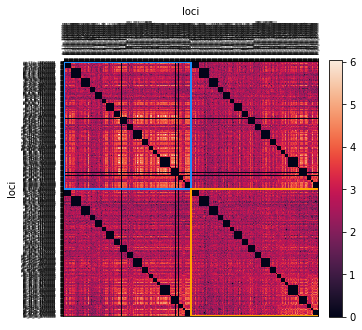

In [30]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1_GM12878.pkl', 'rb'))
# Plot data frame as heatmap
patches_list = [[0,1,len(selected_active_adhesome_loci), len(selected_active_adhesome_loci),'dodgerblue'],
                #[0, len(active_adhesome_loci)+len(inactive_adhesome_loci),len(random_active_non_adhesome_loci),len(random_active_non_adhesome_loci),'green'],
                [len(selected_active_adhesome_loci),len(selected_active_adhesome_loci),len(selected_active_adhesome_loci),len(selected_active_adhesome_loci),'orange']]
loci_list_active = list(itertools.chain.from_iterable([selected_active_adhesome_loci, random_active_non_adhesome_loci]))
lu.plot_heatmap(contacts_df1.loc[loci_list_active,loci_list_active],
                loci_list_active, loci_list_active, 'loci', 'loci', 
                5, contacts_df1.loc[loci_list_active,loci_list_active].max().max(), add_patches = patches_list)

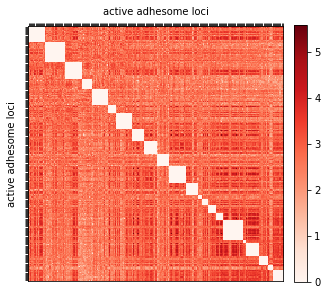

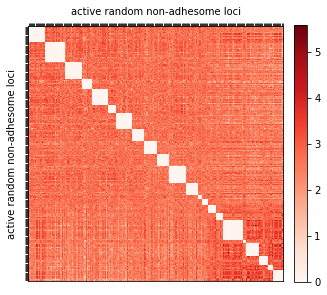

In [64]:
# Load contacts_df1
contacts_df1 = pickle.load(open(saving_dir+'contacts_df1_GM12878.pkl', 'rb'))
loci_list_active = list(itertools.chain.from_iterable([selected_active_adhesome_loci, 
                                                       random_active_non_adhesome_loci]))
# Plot heatmaps
lu.plot_heatmap(contacts_df1.loc[selected_active_adhesome_loci,selected_active_adhesome_loci],
                ['' for _ in selected_active_adhesome_loci], ['' for _ in selected_active_adhesome_loci], 
                'active adhesome loci', 'active adhesome loci', 
                size=5, fontsize=5,
                vmax=contacts_df1.loc[loci_list_active,loci_list_active].max().max(), add_patches = [],
                cmap='Reds')
lu.plot_heatmap(contacts_df1.loc[random_active_non_adhesome_loci,random_active_non_adhesome_loci],
                ['' for _ in random_active_non_adhesome_loci], ['' for _ in random_active_non_adhesome_loci], 
                'active random non-adhesome loci', 'active random non-adhesome loci', 
                size=5, fontsize=5,
                vmax=contacts_df1.loc[loci_list_active,loci_list_active].max().max(), add_patches = [],
                cmap='Reds')

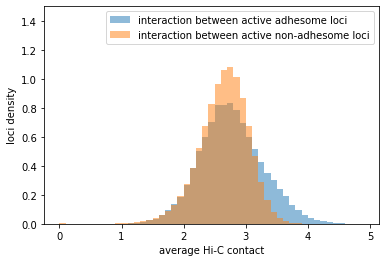

Wilcoxon Rank-Sums test (blue vs orange):
RanksumsResult(statistic=33.3867464771709, pvalue=2.135064899061057e-244)


In [65]:
# Histogram of average Hi-C contacts in three active cases

# Group of active adhesome loci with itself (remove 0 values)
# active_adhesome_hic_with_itself = contacts_df1.loc[active_adhesome_loci,active_adhesome_loci].sum(axis=1).values
# active_adhesome_hic_with_itself = active_adhesome_hic_with_itself/(len(active_adhesome_loci)-np.array([number_active_adhesome_per_chrom[int(l.split('_')[1])] 
#                                                                                                        for l in active_adhesome_loci]))
indices = np.triu_indices(len(contacts_df1.loc[selected_active_adhesome_loci,selected_active_adhesome_loci]))
num_zeros_intraX = sum([int(number_active_adhesome_per_chrom[chrom]*(number_active_adhesome_per_chrom[chrom]+1)/2)
                        for chrom in np.arange(1,22+1,1)])
active_adhesome_hic_with_itself = sorted(contacts_df1.loc[selected_active_adhesome_loci,
                                                selected_active_adhesome_loci].values[indices])[num_zeros_intraX:]
# Group of all active non-adhesome loci with itself
nonadh_contacts_ls = pickle.load(open(saving_dir+'nonadh_contacts_ls_GM12878.pkl', 'rb'))
all_active_nonadhesome_hic_with_itself = nonadh_contacts_ls

# Histogram
plt.figure()
plt.hist(active_adhesome_hic_with_itself, 
         bins=np.arange(0,5,0.1), alpha=0.5, density=True, label='interaction between active adhesome loci')
plt.hist(all_active_nonadhesome_hic_with_itself, 
         bins=np.arange(0,5,0.1), alpha=0.5, density=True, label='interaction between active non-adhesome loci')
plt.xlabel('average Hi-C contact')
plt.ylabel('loci density')
#plt.title('Interchromosomal Hi-C contact distribution')
plt.ylim(0,1.5)
plt.legend(loc='upper right') #, bbox_to_anchor=(1,0.5)
plt.show()
# Tests

print('Wilcoxon Rank-Sums test (blue vs orange):')
print(ss.ranksums(active_adhesome_hic_with_itself,
                  all_active_nonadhesome_hic_with_itself))

In [77]:
# Compare cluster strength to distribution of cluster strengths
cluster_genes = ['CAPN1', 'CFL1', 'MAPK8IP3', 'PKD1', 'STAT3', 'PIP5K1C']
cluster_genes = ['CD151', 'HRAS', 'PLEC', 'SHARPIN', 'SLC16A3']
cluster_loci = np.array(list(itertools.chain.from_iterable([gene2locus[g] for g in cluster_genes])))
cluster_loci_contact = contacts_df1.loc[cluster_loci, cluster_loci]

### Supplement: show HiC connections between chromosomes

In [27]:
# Initialize empty dataframe
chr_list = np.arange(1,22+1)
chr_hic_contact = pd.DataFrame(0,index=chr_list, columns=chr_list)

In [28]:
# List all chromosome pairs
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair
    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))
    # Fill chr_hic_contact with the average Hi-C contact between chr1 and chr2
    chr_hic_contact.loc[chr1,chr2] = hic_chpair_df.mean().mean()
    chr_hic_contact.loc[chr2,chr1] = hic_chpair_df.mean().mean()

100%|██████████| 231/231 [00:03<00:00, 61.14it/s]


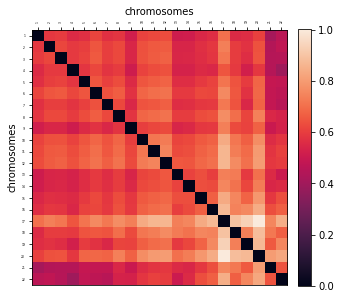

In [29]:
# Plot average HiC contact between all pairs of chromosomes
lu.plot_heatmap(chr_hic_contact, chr_list, chr_list, 'chromosomes', 'chromosomes', 
                5, chr_hic_contact.max().max())